## Import libraries

In [1]:
import pandas as pd
import numpy as np
from ast import literal_eval
import matplotlib.pyplot as plt

from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, accuracy_score
from sklearn.model_selection import GridSearchCV

import re
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer

import warnings
warnings.filterwarnings("ignore")

## Datasets preparation

In [2]:
df= pd.read_csv("moviess.csv")

#### Check information from dataset

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24079 entries, 0 to 24078
Data columns (total 15 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   imdb_id               23504 non-null  object 
 1   title                 24079 non-null  object 
 2   overview              23923 non-null  object 
 3   release_date          24079 non-null  object 
 4   runtime               24079 non-null  int64  
 5   status                24079 non-null  object 
 6   tagline               15736 non-null  object 
 7   adult                 24079 non-null  bool   
 8   vote_average          24079 non-null  float64
 9   vote_count            24079 non-null  int64  
 10  genres                24079 non-null  object 
 11  production_companies  24079 non-null  object 
 12  directors             24079 non-null  object 
 13  actors                24079 non-null  object 
 14  rating_rounded        24079 non-null  int64  
dtypes: bool(1), float64

#### Keep released movies and then drop columns useless

In [4]:
# Keep only the rows where the movie has been released
df = df[(df['status'] == 'Released')]
# Drop the 'status' column
df = df.drop(columns=['release_date', 'imdb_id', 'status', 'rating_rounded'])

In [5]:
df.head(3)

,title,overview,runtime,tagline,adult,vote_average,vote_count,genres,production_companies,directors,actors
0,John Wick: Chapter 4,"With the price on his head ever increasing, Jo...",170,"No way back, one way out.",False,7.979,2337,"['Action', 'Thriller', 'Crime']","['Thunder Road', '87Eleven', 'Summit Entertain...",['Chad Stahelski'],"['Keanu Reeves', 'Donnie Yen', 'Bill Skarsgård..."
1,Fast X,Over many missions and against impossible odds...,142,The end of the road begins.,False,7.058,642,"['Action', 'Crime', 'Thriller']","['Universal Pictures', 'Original Film', 'One R...",['Louis Leterrier'],"['Vin Diesel', 'Michelle Rodriguez', 'Tyrese G..."
2,Sisu,"Deep in the wilderness of Lapland, Aatami Korp...",91,Vengeance is golden.,False,7.533,498,"['Action', 'War']","['Subzero Film Entertainment', 'Good Chaos', '...",['Jalmari Helander'],"['Jorma Tommila', 'Aksel Hennie', 'Jack Doolan..."


## Preprocessing data

We can use the average ratings of the movie as the score but using this won't be fair enough since a movie with 9.0 average rating and only 1 votes cannot be considered better than the movie with 8.5 as as average rating but 100 votes.

We will use this algoritm to calculate movie rating.
![](https://image.ibb.co/jYWZp9/wr.png)

* v is the number of votes for the movie
* m is the minimum votes required to be listed in the chart
* R is the average rating of the movie
* C is the mean vote across the whole report

We already have v(**vote_count**) and R (**vote_average**)

In [6]:
# Define a new feature 'score' and calculate its value
v = df['vote_count']
R = df['vote_average']
C = df['vote_average'].mean()
m = df['vote_count']
df = df.copy().loc[df['vote_count'] >= m]

df['score_rating'] = (v/(v+m) * R) + (m/(m+v) * C)

#### Drop dupplicate data then reset index

In [7]:
df = df.drop(columns=['vote_average', 'vote_count'])
df = df.drop_duplicates(keep='first')
df = df.reset_index(drop=True)

### Remove outlier

In [8]:
def remove_outlier(df_in, col_name, lower_score=0, upper_score=1):
    q1 = df_in[col_name].quantile(lower_score)
    q3 = df_in[col_name].quantile(upper_score)
    iqr = q3-q1 #Interquartile range
    fence_low  = q1-1.5*iqr
    fence_high = q3+1.5*iqr
    df_out = df_in.loc[(df_in[col_name] > fence_low) & (df_in[col_name] < fence_high)]
    return df_out

In [9]:
df = remove_outlier(df, 'score_rating', lower_score=0.2, upper_score=0.85)

In [10]:
# Parse the stringified features into their corresponding python objects
features = ['actors', 'directors', 'production_companies', 'genres']
for feature in features:
    df[feature] = df[feature].apply(literal_eval)

In [11]:
df.head(3)

,title,overview,runtime,tagline,adult,genres,production_companies,directors,actors,score_rating
0,John Wick: Chapter 4,"With the price on his head ever increasing, Jo...",170,"No way back, one way out.",False,"[Action, Thriller, Crime]","[Thunder Road, 87Eleven, Summit Entertainment,...",[Chad Stahelski],"[Keanu Reeves, Donnie Yen, Bill Skarsgård, Ian...",7.19186
1,Fast X,Over many missions and against impossible odds...,142,The end of the road begins.,False,"[Action, Crime, Thriller]","[Universal Pictures, Original Film, One Race, ...",[Louis Leterrier],"[Vin Diesel, Michelle Rodriguez, Tyrese Gibson...",6.73136
2,Sisu,"Deep in the wilderness of Lapland, Aatami Korp...",91,Vengeance is golden.,False,"[Action, War]","[Subzero Film Entertainment, Good Chaos, Stage...",[Jalmari Helander],"[Jorma Tommila, Aksel Hennie, Jack Doolan, Mim...",6.96886


#### Check null values on each features

In [12]:
df.isnull().sum()

title                      0
overview                  52
runtime                    0
tagline                 5018
adult                      0
genres                     0
production_companies       0
directors                  0
actors                     0
score_rating               0
dtype: int64

#### Process null values

In [13]:
# Replace missing 'tagline' and 'overview' with ''
df['overview'].fillna('', inplace=True)
df['tagline'].fillna('', inplace=True)
df.dropna(inplace=True)

## EDA

Text(0.5, 1.0, 'Highest Score Movies')

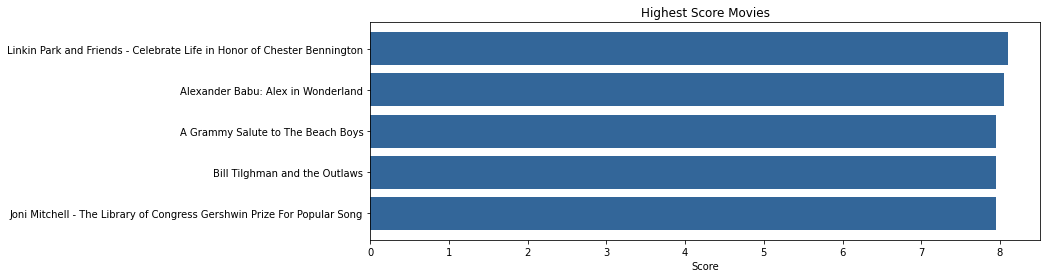

In [14]:
score_movie = df.sort_values('score_rating', ascending=False)[:5]

plt.figure(figsize=(12,4))
plt.barh(score_movie['title'], score_movie['score_rating'], align='center', color=(0.2, 0.4, 0.6))

plt.gca().invert_yaxis()
plt.xlabel("Score")
plt.title("Highest Score Movies")

**The movie with the highest score_rating is "Linkin Park and Friends - Celebrate Life in Hollywood" with a score_rating of 8.10236. This indicates that it received the highest rating among the movies in the list.**

**"Linkin Park and Friends - Celebrate Life in Hollywood" is a music-focused movie, but specific details such as the overview, tagline, production companies, directors, and actors are not provided in the dataframe. The movie has a runtime of 180 minutes and is not categorized as an adult film.**

**The high score_rating suggests that it was well-received and highly regarded by viewers or critics who rated it. The involvement of Linkin Park and other artists may have contributed to its popularity.**

**Please note that the score_rating is subjective and may vary among different viewers. It's always recommended to explore reviews and ratings from multiple sources to get a comprehensive understanding of a movie's quality.**

Text(0.5, 1.0, 'Lowest Score Movies')

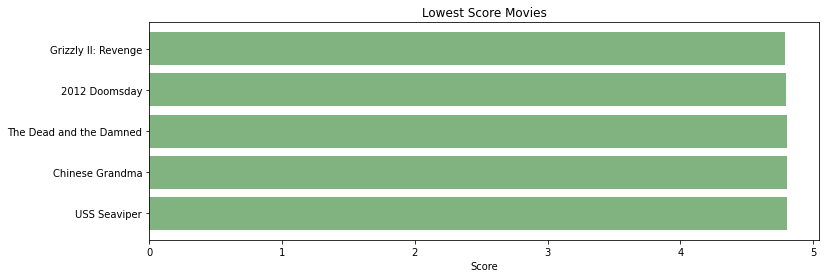

In [15]:
score_movie = df.sort_values('score_rating', ascending=True)[:5]

plt.figure(figsize=(12,4))
plt.barh(score_movie['title'], score_movie['score_rating'], align='center', color=(0.5, 0.7, 0.5))

plt.gca().invert_yaxis()
plt.xlabel("Score")
plt.title("Lowest Score Movies")

**The movie with the lowest score_rating is "Grizzly II: Revenge" with a score_rating of 4.78886. This indicates that it received a relatively low rating compared to the other movies in the list.**

**"Grizzly II: Revenge" is a horror, music, and thriller film where all hell breaks loose when a giant grizzly seeks revenge. The movie has a runtime of 74 minutes and is directed by André Szöts. It features actors such as Steve Inwood, Deborah Raffin, and John Rhys-Davies.**

**It's important to note that the score_rating is subjective and may vary among different viewers. The low rating of "Grizzly II: Revenge" suggests that it may not have been well-received by the audience or critics. However, it's always recommended to explore reviews and ratings from multiple sources to get a comprehensive understanding of a movie's quality and make your own judgment.**

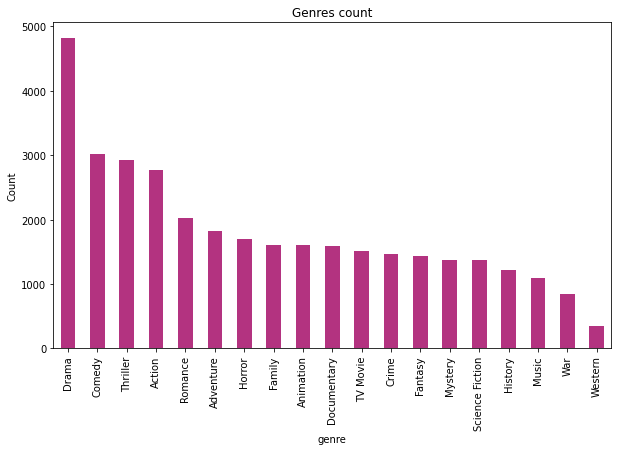

In [16]:
df_genre = df['genres'].apply(pd.Series).stack().reset_index(level=1, drop=True).reset_index(name='genre').drop('index', axis=1)

plt.figure(figsize=(10, 6))
df_genre.groupby('genre')['genre'].count().sort_values(ascending=False).plot(kind='bar', color=(0.7, 0.2, 0.5))
plt.title("Genres count")
plt.ylabel('Count')
plt.show()

**Drama is the most common genre, with 4822 movies falling under this category. Drama films typically focus on emotional themes and character development, making them a popular choice among filmmakers and audiences.**

**Comedy is the second most prevalent genre, with 3021 movies. Comedy films aim to entertain and make the audience laugh, offering light-hearted and humorous storytelling.**

**Thriller is the third most common genre, with 2920 movies. Thrillers typically involve suspense, tension, and excitement, keeping the audience engaged with unpredictable plot twists and intense storytelling.**

**Action and Romance genres follow closely with 2765 and 2024 movies, respectively. Action movies offer thrilling sequences, stunts, and often involve conflicts or battles. Romance films revolve around love and relationships, appealing to audiences seeking emotional connections and heartwarming narratives.**

**Adventure, Horror, Family, and Animation genres also have a significant presence, each with over 1500 movies. Adventure films often involve exciting journeys and exploration. Horror movies aim to evoke fear and suspense, while family and animation genres cater to younger audiences and offer wholesome, engaging content.**

**Documentary and TV Movie genres have relatively high counts as well, with 1594 and 1517 movies, respectively. Documentaries provide factual and informative content, while TV movies are made for television broadcasts and cover a wide range of genres and topics.**

**Crime, Fantasy, Mystery, Science Fiction, History, Music, War, and Western genres have varying levels of representation, each with several hundred movies.**

**Overall, the conclusions from this genre distribution indicate that there is a diverse range of movie genres available, catering to different tastes and preferences of audiences. Drama, Comedy, Thriller, Action, and Romance remain popular choices, while genres like Documentary, Family, and Animation also have significant followings.**

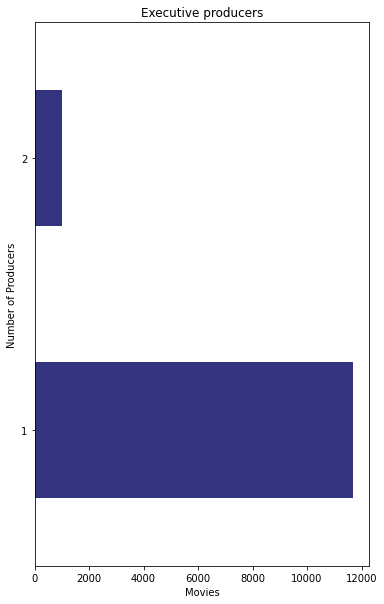

In [17]:
df_prod = df['directors'].apply(len).reset_index(name='prod').drop('index', axis=1)

plt.figure(figsize=(6, 10))
df_prod.groupby('prod')['prod'].count().sort_values(ascending=False)[:2].plot(kind='barh', color=(0.2, 0.2, 0.5))
plt.title("Executive producers")
plt.ylabel('Number of Producers')
plt.xlabel('Movies')
plt.show()

**The majority of movies in the dataset are directed by a single director, accounting for 11,703 instances. This suggests that solo directorship is the most common approach in filmmaking. However, there are also 1,006 movies that involve multiple directors, indicating that collaborative directorial efforts are present but less prevalent in the dataset.**

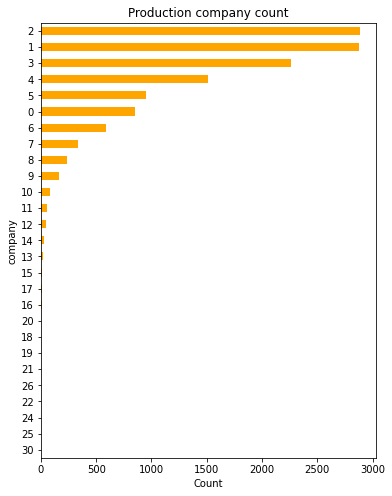

In [18]:
df_company = df['production_companies'].apply(len).reset_index(name='company').drop('index', axis=1)

plt.figure(figsize=(6, 8))
df_company.groupby('company')['company'].count().sort_values(ascending=True).plot(kind='barh', color='orange')
plt.title("Production company count")
plt.xlabel('Count')
plt.show()

**The majority of movies in the dataset are produced by either two production companies or a single production company, with 2,885 and 2,875 instances respectively. This suggests that movies commonly involve collaborations between two companies or are produced by a single company. However, there are also movies that involve a higher number of production companies, with the count gradually decreasing as the number of companies involved increases.**

## Machine learning and Deep learning

#### Encode object column

In [19]:
# Initialize LabelEncoder
le = LabelEncoder()

# Fit and transform 'adult' column
df['adult'] = le.fit_transform(df['adult'])

#### Processing text feature

In [20]:
def process_text_list(list_value):
    return ' '.join(list_value)

In [21]:
df['genres'] = df['genres'].apply(process_text_list)
df['production_companies'] = df['production_companies'].apply(process_text_list)
df['directors'] = df['directors'].apply(process_text_list)
df['actors'] = df['actors'].apply(process_text_list)

In [22]:
stop_words = set(stopwords.words('english'))
st = SnowballStemmer('english')

In [23]:
def clean_text_data(df_in, col):
    # change to lower and remove spaces on either side
    df_in[col] = df_in[col].apply(lambda x: x.lower().strip())
    # remove extra spaces in between
    df_in[col] = df_in[col].apply(lambda x: re.sub(' +', ' ', x))
    # remove punctuation
    df_in[col] = df_in[col].apply(lambda x: re.sub('[^a-zA-Z]', ' ', x))
    # remove stopwords and get the stem
    df_in[col] = df_in[col].apply(lambda x: ' '.join(st.stem(text) for text in x.split() if text not in stop_words))
    return df_in[col]

In [24]:
df['overview'] = df['overview'].astype(str)

In [25]:
df['overview'] = clean_text_data(df, 'overview')
df['genres'] = clean_text_data(df, 'genres')
df['production_companies'] = clean_text_data(df, 'production_companies')
df['directors'] = clean_text_data(df, 'directors')
df['actors'] = clean_text_data(df, 'actors')

In [26]:
def create_soup(x):
    return x['title'] + ' ' + x['overview'] + ' ' + x['tagline'] + ' ' + x['genres'] + ' ' + x['production_companies'] + ' ' + x['directors'] + ' ' + x['actors']

In [27]:
df['soup'] = df.apply(create_soup, axis=1)

df = df.drop(columns=['title', 'overview', 'tagline', 'genres', 'production_companies', 'directors', 'actors'])

#### Normalization

In [28]:
scaler = StandardScaler()
df['runtime'] = scaler.fit_transform(np.array(df['runtime']).reshape(-1, 1))

In [29]:
df = df.reset_index(drop=True)

#### Embedding text features

In [30]:
from sentence_transformers import SentenceTransformer
embedding_model = SentenceTransformer('paraphrase-MiniLM-L3-v2')

# encode all sentences
embeddings = embedding_model.encode(df['soup'], batch_size=512, show_progress_bar=True)

Batches:   0%|          | 0/26 [00:00<?, ?it/s]

In [31]:
df_text = pd.DataFrame(embeddings)
df = pd.concat([df, df_text], axis=1)

In [32]:
df = df.drop(['runtime', 'soup', 'adult'], axis=1) #only keep text data

In [33]:
df.head(3)

,score_rating,0,1,2,3,4,5,6,7,8,...,374,375,376,377,378,379,380,381,382,383
0,7.19186,0.049993,-0.008717,0.024690,0.008969,0.063074,-0.077994,0.223947,-0.043536,0.122065,...,-0.094407,0.304338,-0.118443,-0.053338,-0.083642,-0.146300,-0.028733,-0.235244,-0.041871,-0.171734
1,6.73136,-0.151657,0.139662,-0.024836,0.007468,0.135099,-0.106904,0.116109,0.110023,0.113366,...,0.033366,0.079112,-0.059080,-0.542577,0.023766,0.080396,0.226773,0.050518,0.147551,0.087656
2,6.96886,0.091568,-0.034332,0.179383,0.026452,-0.146983,-0.174554,0.335386,0.123930,0.198424,...,0.186103,0.055713,-0.227691,-0.233185,0.218381,0.151435,0.140904,0.095704,-0.006612,0.102342


#### Split data to train and test

In [34]:
# divide the data into (X) and (y)
X = df.drop('score_rating', axis=1)
y = df['score_rating']

In [35]:
# Splitting the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## Machine learning

#### Gridsearch Best parameters

In [37]:
parameters_rf = {'max_depth':[1, 3, 5], 'n_estimators':[100, 150, 200]}
rf_grid = GridSearchCV(RandomForestRegressor(), parameters_rf)
rf_grid.fit(X_train, y_train)

parameters_svm = {'kernel':('linear', 'rbf'), 'C':[1, 3, 5]}
svm_grid = GridSearchCV(SVR(), parameters_svm)
svm_grid.fit(X_train, y_train)

GridSearchCV(estimator=SVR(),
             param_grid={'C': [1, 3, 5], 'kernel': ('linear', 'rbf')})

In [38]:
print("Best parameters of Random Forest:", rf_grid.best_params_)
print("Best parameters of SVM:", svm_grid.best_params_)

Best parameters of Random Forest: {'max_depth': 5, 'n_estimators': 150}
Best parameters of SVM: {'C': 1, 'kernel': 'rbf'}


#### Train model with best parameters

In [36]:
rf = RandomForestRegressor(n_estimators=150, max_depth=5)
rf.fit(X_train, y_train)

svm = SVR(C=1, kernel='rbf')
svm.fit(X_train, y_train)

SVR(C=1)

In [37]:
svm_pred = svm.predict(X_test)
rf_pred = rf.predict(X_test)

#### Evaluation

In [38]:
print("MAE score of SVM: ", mean_absolute_error(y_test, svm_pred,))
print("MAE score of Random Forest: ", mean_absolute_error(y_test, rf_pred))
print('-' * 100)
print("MSE score of SVM: ", mean_squared_error(y_test, svm_pred))
print("MSE score of Random Forest: ", mean_squared_error(y_test, rf_pred))

MAE score of SVM:  0.3290265606584648
MAE score of Random Forest:  0.35423617295523235
----------------------------------------------------------------------------------------------------
MSE score of SVM:  0.18420446060620616
MSE score of Random Forest:  0.2053797939641477


**Based on the Mean Absolute Error (MAE) scores, the SVM model outperforms the Random Forest model with a lower value of 0.329 compared to 0.354. Similarly, in terms of Mean Squared Error (MSE) scores, the SVM model performs better with a lower value of 0.184 compared to 0.206 for the Random Forest model. Therefore, the SVM model shows better accuracy in predicting the target variable compared to the Random Forest model.**

## Deep learning

In [39]:
from tensorflow import keras
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, BatchNormalization, Dropout

### Model

In [40]:
model_ann = Sequential()
model_ann.add(Dense(512, input_dim=X_train.shape[1]))
model_ann.add(Activation('relu'))
model_ann.add(Dense(128))
model_ann.add(Activation('relu'))
model_ann.add(Dense(128))
model_ann.add(Activation('relu'))
model_ann.add(Dense(64))
model_ann.add(Activation('relu'))
model_ann.add(Dropout(0.3))
model_ann.add(Dense(1))

This model is a sequential neural network with multiple hidden layers consisting of dense (fully connected) layers. It uses the ReLU activation function to introduce non-linearity and dropout regularization to prevent overfitting. The final layer is a single neuron without an activation function, indicating a regression task.

### Optimizer

In [41]:
opt = keras.optimizers.Adam(learning_rate=0.001)
model_ann.compile(loss="mse", optimizer=opt)

This model is compiled with the mean squared error (MSE) loss function, indicating a regression task. It uses the Adam optimizer with a learning rate of 0.001, which is a popular choice for gradient-based optimization. The combination of MSE loss and Adam optimizer suggests that the model aims to minimize the mean squared error between the predicted and actual values during training.

### Training

In [ ]:
history = model_ann.fit(np.array(X_train), np.array(y_train), 
                        epochs=500, batch_size=512, validation_data=(np.array(X_test), np.array(y_test)))  


#### Evaluation

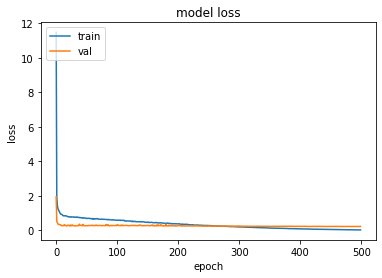

In [43]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [44]:
y_pred_ann = model_ann.predict(np.array(X_test)).flatten()

In [45]:
print("MAE score of Neural Network: ", mean_absolute_error(y_test, y_pred_ann))
print('-' * 100)
print("MSE score of Neural Network: ", mean_squared_error(y_test, y_pred_ann))

MAE score of Neural Network:  0.3732167240522942
----------------------------------------------------------------------------------------------------
MSE score of Neural Network:  0.23135393608305946


## Comparison

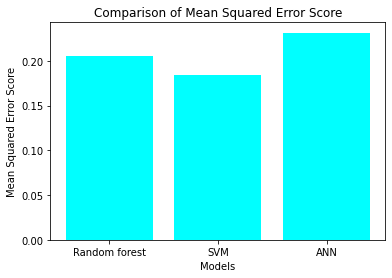

In [46]:
models = ['Random forest', 'SVM', 'ANN']
sc = [mean_squared_error(y_test, rf_pred), mean_squared_error(y_test, svm_pred), 
      mean_squared_error(y_test, y_pred_ann)]
plt.bar(models, sc, align='center', color='cyan')
plt.xlabel('Models')
plt.ylabel('Mean Squared Error Score')
plt.title('Comparison of Mean Squared Error Score')
plt.show()

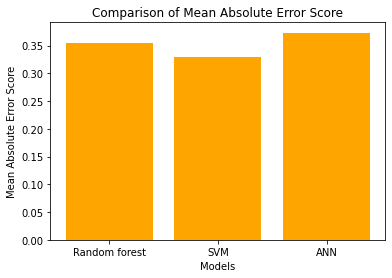

In [48]:
models = ['Random forest', 'SVM', 'ANN']
sc = [mean_absolute_error(y_test, rf_pred), mean_absolute_error(y_test, svm_pred), 
      mean_absolute_error(y_test, y_pred_ann)]
plt.bar(models, sc, align='center', color='orange')
plt.xlabel('Models')
plt.ylabel('Mean Absolute Error Score')
plt.title('Comparison of Mean Absolute Error Score')
plt.show()

**=> Comparing the results, the Neural Network model has a higher MAE score of 0.380 compared to the SVM model's score of 0.329. Additionally, the Neural Network model has a higher MSE score of 0.239 compared to the SVM model's score of 0.184. This indicates that the SVM model performs better in terms of accuracy and precision compared to the Neural Network model in predicting the target variable.**